# Geomagnetic Conjugate Map
The purpose of this notebook is to gather relevant stations and mapping information for a geomagnetic conjugate map.

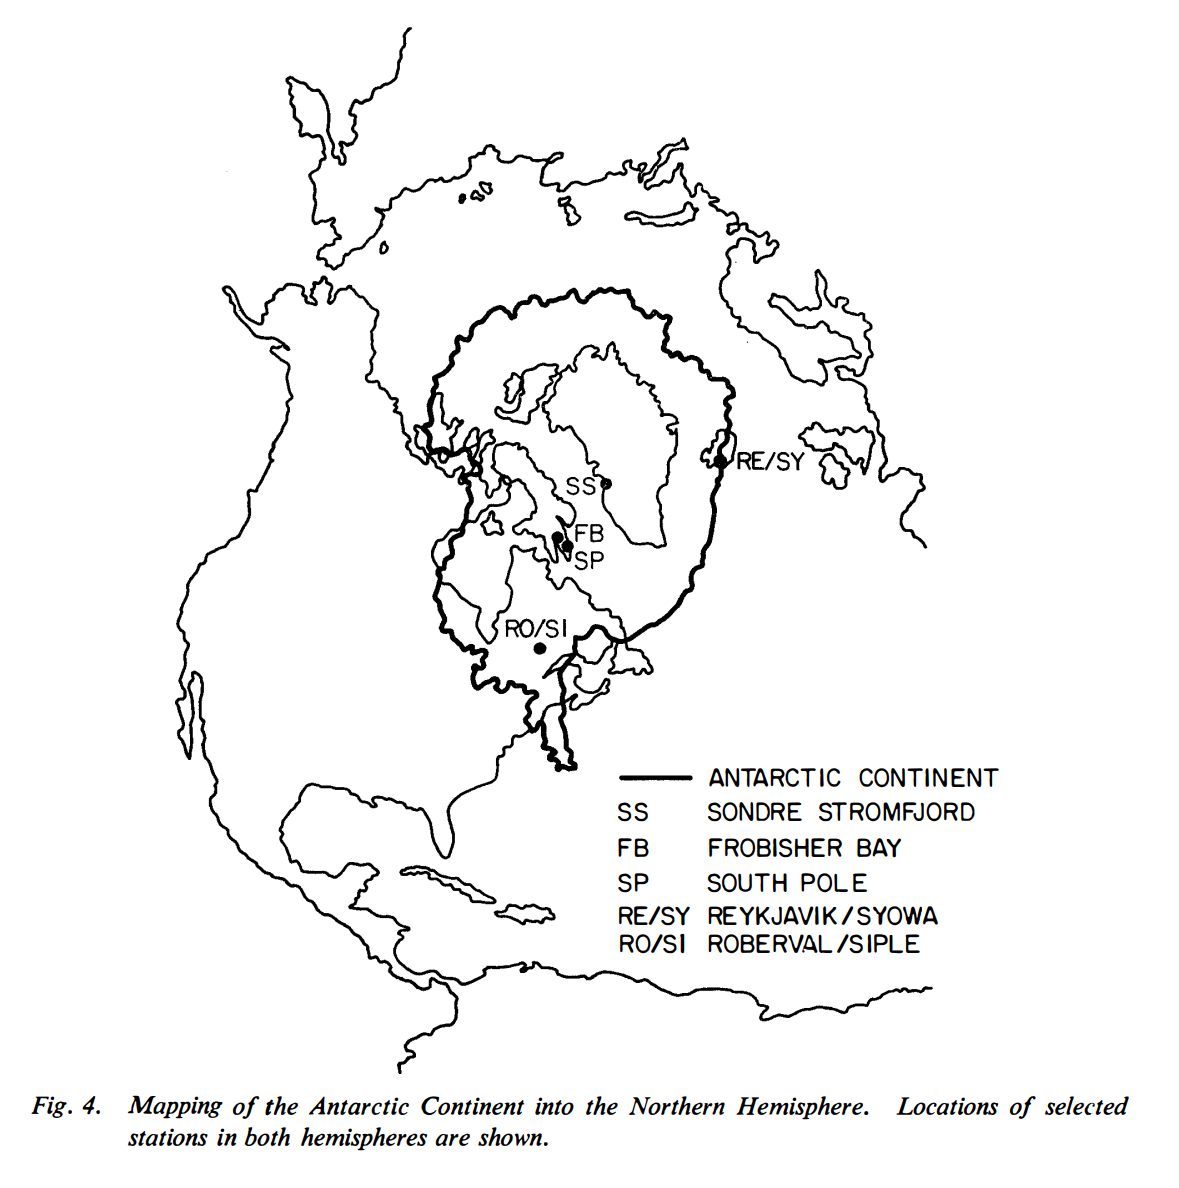

In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import ogr
import geopandas as gpd

## Stations and Features
First, let's collect stations and features of interest into pandas dataframes. (Make sure to include dates of operation wherever possible - want to make sure that we have that information when creating historical maps later!)

### Marc Engebretson's wish list:

- [ ] *TODO*: Get each of these into a spreadsheet/dataframe and import them to this notebook accordingly.

- [ ] Figure 1 and Table 1 in the attached file “JGRA – 2022 – Engebretson…”  show stations used in one of my recent papers.  The table contains a full list of AAL-PIP stations in Antarctica but only a partial list of stations in the other arrays mentioned.  In Figure 1 the stations in one high latitude hemisphere are mapped to their magnetically conjugate region in the other hemisphere. 
- [ ] Greenland coastal arrays:  a web site with the full list of west coast and east coast stations is
https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_ground_stations#list  
Only one of the stations on the Greenland Ice Cap is still operating. See tables in doi.org/10.1029/2022JA030580

- [ ] British Antarctic survey chain:  Coordinates are part of the station name, as in “M85-002 – 85.36° 2.06°” in Table 1 of the attached file “JGRA – 2022 – Engebretson…”.  The full list of stations is in the attached file ”Full Record – LPM…” https://www.bas.ac.uk/project/low-power-magnetometer-lpm-network/
- [ ] AUTUMNX array coordinates are in the attached file “Connors2016…..”  doi.org/10.1186/s40623-015-0354-4 See Figure 4 (yellow circles) and Table 1.  They are also available at https://autumn.athabascau.ca/TBS_autumnxquery2.php
- [ ] MACCS array coordinates are in the attached file “MACCS array and…”  (see link below)
- [ ] CANMOS array geographic coordinates are listed here:  https://geomag.nrcan.gc.ca/obs/default-en.php

### Antarctic Stations
- [x] AALPIP stations
- [ ] Import COMNAP data - use https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/tree/master
- [ ] Macquire Island station

### Northern Hemisphere Stations
- [ ] AMISR - should be conjugate with McMurdo
- [ ] MACCS network
- [ ] North American research institutions (CWRU, MIT, NJIT, VA Tech, DTU, and other universities who have space wx/have expressed interest)
- [ ] ISRs
- [ ] All-sky cameras
- [ ] Full set of magnetometer networks from SuperMAG

#### MACCS
http://space.augsburg.edu/maccs/coordinates.html
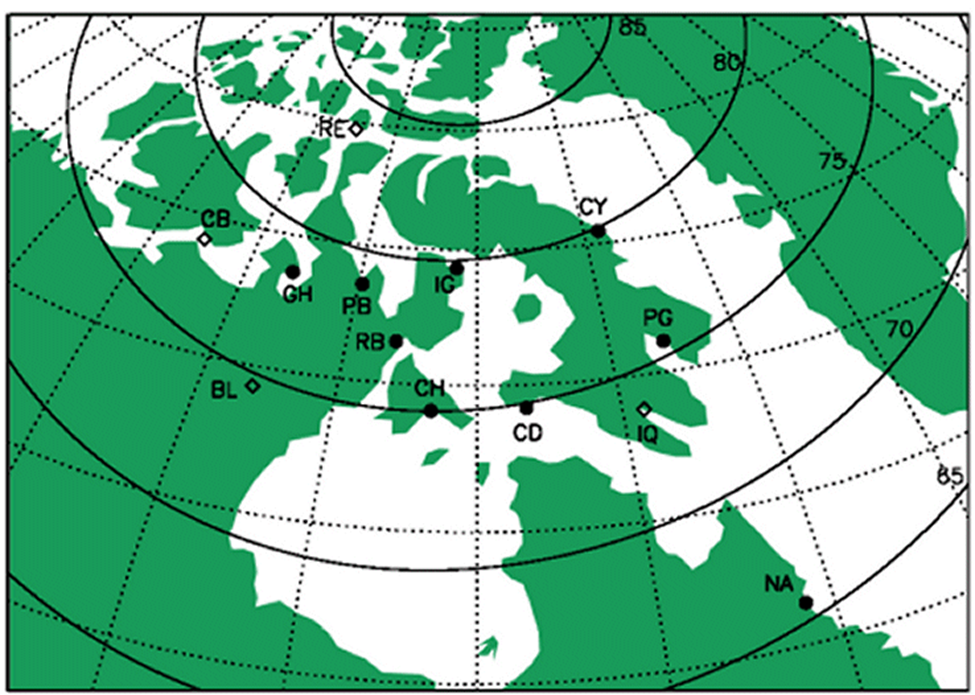


### Eclipse Paths
- [ ] June 2020 Eclipse 
- [ ] December 2020 Eclipse 

### Satellite Paths
- [ ] GOES East

## Maps

### Global Map
- [ ] Let's begin by plotting all the points on a globe map using plotly express.

### Antarctic Coastline
- [X] Pull data from https://data.bas.ac.uk/items/70ac5759-34ee-4f39-9069-2116db592340/#item-details-citation
- [ ] Map the data with plotly express or similar
- [ ] Convert the coordinates to geomagnetic coordinates and plot them

In [8]:
with open('antarctic_coastline.json') as f:
  Antarctic_coast = json.load(f)

In [10]:
Antarctic_coast["features"][0]['properties']

{'surface': 'ice coastline',
 'sourcedate': '2009-10-05',
 'updater': 'Risse',
 'revdate': 'June 2014',
 'source': 'WV01',
 'lineage': '1020010009546500'}

### Coordinate Conversions
- [ ] Create/find a function to convert geographic to geomagnetic coordinates. Might try https://pypi.org/project/aacgmv2/ or https://github.com/space-physics/geo2mag

## Citations
- Please cite this item as 'Gerrish, L., Ireland, L., Fretwell, P., & Cooper, P. (2023). High resolution vector polylines of the Antarctic coastline (7.7) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/70ac5759-34ee-4f39-9069-2116db592340'. If using for a graphic or if short on space, please cite as 'data from the SCAR Antarctic Digital Database, 2023'